In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json
import pandas as pd
import scipy.optimize as sp
import itertools

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py

In [45]:
#run_dir = "mag_ratio_bdry_pass2/"
run_dir = "/home/guaravtenkila/Disorder_sims/Ising_RSRG/log_bdry_output/bdry_mag_test/"


log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
#log_file['L'].tolist()
selected_files = log_file
selected_files

ts_list = selected_files['ts'].tolist()
n_runs_list = selected_files['n_runs'].tolist()
L_list = selected_files['L'].tolist()

selected_files

,L,steps,w_blk,w_bdry,w_mixed,n_runs,runtime,ts
0,"(10, 10)",99,6.6,2.5,6.6,960,5.591538,979978431025.066.0


In [6]:
def output_reader_bdry(measure_list, fname):
    hblk_dist_dict = [{} for _ in range(len(measure_list))]
    hbdry_dist_dict = [{} for _ in range(len(measure_list))]
    J_blk_blk_dict = [{} for _ in range(len(measure_list))]
    J_bdry_bdry_dict = [{} for _ in range(len(measure_list))]
    J_blk_bdry_dict = [{} for _ in range(len(measure_list))]

    #In2029_hbd_m19

    with open(fname, 'r') as reader:
        next(reader)
        for line in reader:
            if line[6]=='_': inst_end = 6
            elif line[7]=='_': inst_end = 7
            else: print("Read error")
            inst_num = int(line[2:inst_end])
            coupling_type = line[inst_end+1:inst_end+4]
            measure_ind = int(line[inst_end+6:inst_end+8])
            couplings = np.array(json.loads(line[inst_end+8:]))
            
            if coupling_type=='hbl':
                hblk_dist_dict[measure_ind][inst_num] = couplings
            elif coupling_type=='hbd':
                hbdry_dist_dict[measure_ind][inst_num] = couplings
            elif coupling_type== 'Jll':
                J_blk_blk_dict[measure_ind][inst_num] = couplings
            elif coupling_type== 'Jrr':
                J_bdry_bdry_dict[measure_ind][inst_num] = couplings
            elif coupling_type== 'Jlr':
                J_blk_bdry_dict[measure_ind][inst_num] = couplings
    return hblk_dist_dict, hbdry_dist_dict, J_blk_blk_dict, J_bdry_bdry_dict, J_blk_bdry_dict

In [51]:
def linear_fit(x, a ,b):
    return x*a + b


L = 80
#fixed_length_slice = log_file[log_file['L']==L]
fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 50)')]
ts_list = np.array(fixed_length_slice['ts'].tolist())
n_bins_h, n_bins_J = 40, 40
free_spins_comp = []
intercept_list_comp = []
slope_list_comp = []
marker_list = []

for index,ts in enumerate(ts_list):

    with open(run_dir+"LIsingB_2D_input_"+str(ts)+".pkl", "rb") as fp:   
        input_dict = pickle.load(fp)
    
    measure_list = input_dict['measure_list']
    fname = run_dir+"LIsingB_2D_output_"+ts+".txt"
    
    hblk_dist_dict, hbdry_dist_dict, \
    J_blk_blk_dict, J_bdry_bdry_dict, J_blk_bdry_dict = output_reader_bdry(measure_list, fname)
    
    hblk_dist_list, hbdry_dist_list = [], []
    J_blk_blk_list, J_blk_bdry_list, J_bdry_bdry_list = [], [], []
    for i in range(len(measure_list)-1):
        hblk_dist_list.append(np.concatenate(tuple(hblk_dist_dict[i].values())))
        hbdry_dist_list.append(np.concatenate(tuple(hbdry_dist_dict[i].values())))
        J_blk_blk_list.append(np.concatenate(tuple(J_blk_blk_dict[i].values())))
        J_blk_bdry_list.append(np.concatenate(tuple(J_blk_bdry_dict[i].values())))
        J_bdry_bdry_list.append(np.concatenate(tuple(J_bdry_bdry_dict[i].values())))
    
    #h_dist_list, J_dist_list = output_reader(measure_list, run_dir+"LIsing_2D_output_"+str(ts)+".txt")
    
    Lx, Ly = input_dict['L']
    spins_left = Lx*Ly - measure_list
    
    intercept_list = []
    slope_list = []
    free_spins = []
    
    for i,step in enumerate(spins_left[:-1]): 

        n,bins = np.histogram(hblk_dist_list[i], bins = n_bins_h, density=True, range=(0,12))
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)
        y = n
        popt, pcov = curve_fit(exponential_dist_norm, x[1:10], y[1:10])
        R0_width = 1/popt[0]

        n,bins = np.histogram(J_blk_blk_list[i], bins = n_bins_J)
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)/R0_width
        y = n/step/width/input_dict['n_runs']
        
        popt, pcov = curve_fit(linear_fit, x[1:], y[1:])
        slope_list.append(popt[0])
        intercept_list.append(popt[1])
        free_spins.append(step)
        
    free_spins_comp.append(free_spins)
    slope_list_comp.append(slope_list)
    intercept_list_comp.append(intercept_list)


Text(0, 0.5, 'Slope parameter')

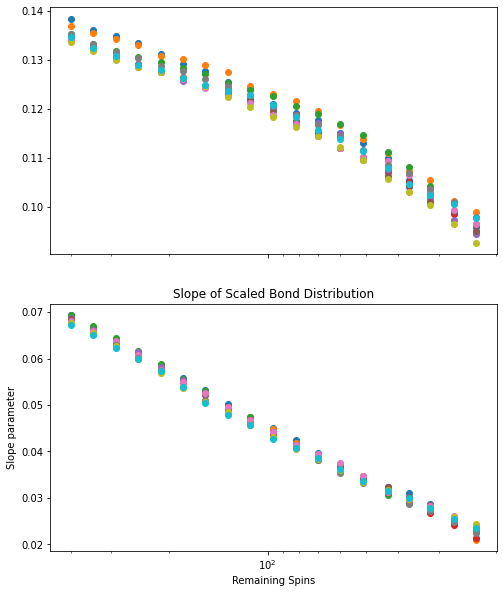

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
w_vals = fixed_length_slice['w_blk'].tolist()
#plt.figure(figsize=(8, 6))

for index,ts in enumerate(ts_list):
    #if marker_list[index] != 'x': continue
    axs[0].scatter(free_spins_comp[index], intercept_list_comp[index], label=str(w_vals[index]))
    axs[1].scatter(free_spins_comp[index], slope_list_comp[index])
    #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
#plt.yscale('log')
plt.title("Slope of Scaled Bond Distribution")
plt.xlabel("Remaining Spins")
plt.ylabel("Slope parameter")
#plt.scatter(L*L, 0.1, marker='^')
#axs[0].legend()

Text(0, 0.5, 'Intercept parameter')

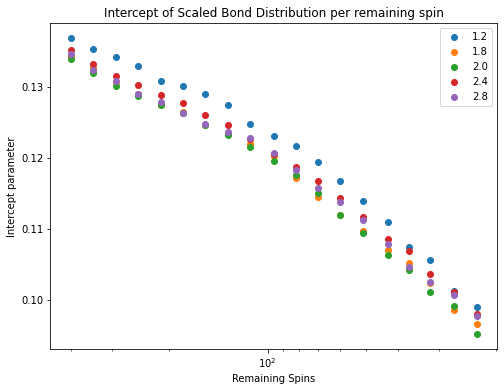

In [56]:
plt.figure(figsize=(8, 6))
w_vals = fixed_length_slice['w_bdry'].tolist()

for index,ts in enumerate(ts_list):
    #if marker_list[index] != 'x': continue
    if index%2==0: continue
    plt.scatter(free_spins_comp[index], intercept_list_comp[index], label=str(w_vals[index]))
    #axs[1].scatter(free_spins_comp[index], slope_list_comp[index])
    #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.legend()
#plt.yscale('log')
plt.title("Intercept of Scaled Bond Distribution per remaining spin")
plt.xlabel("Remaining Spins")
plt.ylabel("Intercept parameter")

[  2.34052677 -12.31525326]


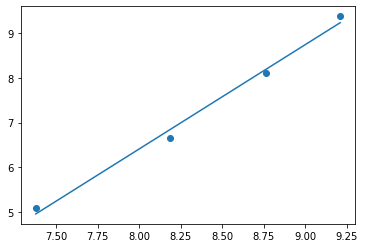

In [22]:
x = np.log(np.array([40, 60, 80, 100])**2)
y = np.log(np.array([160.07, 785.75, 3338.23, 11929.61]))

plt.scatter(x, y)
def lin_fit(x, m, c):
    return m*x + c

popt, pcov = curve_fit(lin_fit, x, y)

plt.plot(x, lin_fit(x, *popt))
print(popt)

In [46]:
Lx_list = [10]
Ly_list = [10]
c_dict = {30: 'orange', 20:'red', 40:'blue', 80:'green', 32:'magenta', 48:'purple'}

w_vals_comp = []
log_gap_comp = []

for Lx in Lx_list:
    for Ly in Ly_list:
        log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
        #Lx, Ly = Lx, L
        rect_side = "(%d, %d)"%(Lx, Ly)
        fixed_length_slice = log_file[lambda df: (df['L']==rect_side)]
        ts_list = fixed_length_slice['ts'].tolist()
        n_runs_list = fixed_length_slice['n_runs'].tolist()
        w_vals = fixed_length_slice['w_bdry'].tolist()
        average_log_gap = []
        
        for index, ts in enumerate(ts_list):
            """
            with open(run_dir+"LIsingB_2D_input_"+ts+".pkl", "rb") as fp:   
                input_dict = pickle.load(fp)

            fname = run_dir+"LIsingB_2D_output_"+ts+".txt"
    
            hblk_dist_dict, hbdry_dist_dict, \
            J_blk_blk_dict, J_bdry_bdry_dict, J_blk_bdry_dict = output_reader_bdry(measure_list, fname)

            for i in range(1, len(measure_list)):
                if hblk_dist_dict[-i]=={} and hbdry_dist_dict[-i]=={}: continue
                else:
                    if not hblk_dist_dict[-i]=={}:
                        log_gap_list_blk = np.concatenate(tuple(hblk_dist_dict[-i].values()))
                    if not hbdry_dist_dict[-i]=={}:
                        log_gap_list_bdry = np.concatenate(tuple(hbdry_dist_dict[-i].values()))
                    break
            log_gap_list = np.concatenate((log_gap_list_blk, log_gap_list_bdry))
            """
            with open(run_dir+"LIsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
                clust_list_final = pickle.load(fp)

            #print(input_dict)
            final_bdry_clust_list = []


            for core_pair in clust_list_final:
                final_bdry_clust_temp = core_pair[-1]
                final_bdry_clust_list+=final_bdry_clust_temp
            
            
            #average_log_gap.append(log_gap_list.mean())
        #w_vals_comp.append(w_vals)
        #log_gap_comp.append(average_log_gap)

In [48]:
sum([1, 2, 3])

6

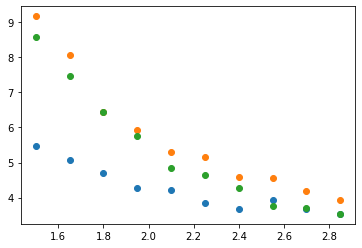

In [40]:
size_list = []
gap_list = []

for i, Lx in enumerate(Lx_list):
    for j, Ly in enumerate(Ly_list):
        ind = len(Ly_list)*i+j
        
        try:
            index = np.where(np.array(w_vals_comp[ind])==2.4)[0][0]
        except:
            continue
        size_list.append(np.sqrt(Lx*Ly))
        gap_list.append(log_gap_comp[ind][index])
        plt.scatter(w_vals_comp[ind], log_gap_comp[ind])

In [41]:
w_vals_comp[ind]

[1.5, 1.65, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55, 2.7, 2.85]

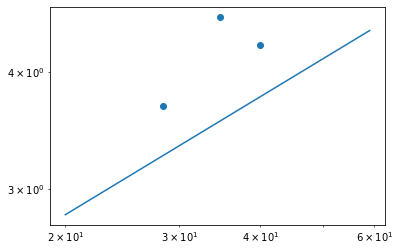

In [44]:
plt.scatter(size_list, gap_list)
plt.yscale('log')
plt.xscale('log')

plt.plot(np.arange(20, 60), 0.8*np.array(np.arange(20, 60))**(0.42))